In [17]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [18]:
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
print('notebook_dir', notebook_dir)
data_folder = 'gpmpc_acados/results'
data_folder_path = os.path.join(notebook_dir, data_folder)
assert os.path.exists(data_folder_path), 'data_folder_path does not exist'
print('data_folder_path', data_folder_path)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
s = 2 # times of std

notebook_dir /home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor
data_folder_path /home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/gpmpc_acados/results


In [19]:
def extract_rollouts(notebook_dir, data_folder, controller_name, additional=''):
    # print('notebook_dir', notebook_dir)
    data_folder_path = os.path.join(notebook_dir, controller_name, data_folder)
    # print('data_folder_path', data_folder_path)
    assert os.path.exists(data_folder_path), 'data_folder_path does not exist'

    # find all the subfolders in the data_folder_path
    subfolders = [f.path for f in os.scandir(data_folder_path) if f.is_dir()]
    # print('subfolders', subfolders)
    # load the row 'rmse in the metrics.txt
    metrics = []
    traj_resutls = []
    for subfolder in subfolders:
        file_path = os.path.join(subfolder, 'metrics.txt')
        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if not line.startswith('rmse_std') and line.startswith('rmse'):
                    # split the text between : and \n
                    line = line.split(': ')[-1].split('\n')[0]
                    metrics.append(eval(line))

        # find the file ends with pickle and get the data
        for file in os.listdir(subfolder):
            if file.endswith('.pkl'):
                file_path = os.path.join(subfolder, file)
                # print('file_path', file_path)
                results = np.load(file_path, allow_pickle=True)
                traj_data = results['trajs_data']['obs'][0]
                traj_resutls.append(traj_data)

    print('traj_results.shape', traj_resutls)
    traj_resutls = np.array(traj_resutls)
    traj_file_name = f'traj_results_{controller_name}{additional}.npy'
    np.save(traj_file_name, traj_resutls)
    print('traj_results.shape', traj_resutls.shape)
    # print('metrics', metrics)
    rmse_mean_mpc = np.mean(metrics)
    rmse_std_mpc = np.std(metrics)
    print(f'rmse_{controller_name}{additional}', rmse_mean_mpc, rmse_std_mpc)
    return traj_resutls, metrics


In [20]:
class benchmark_rmse_data:
    # data stored in the path like "prior/seed/figs/"
    # each data is a csv file
    def __init__(self, data_folder_path, controller_name, prior_name, dt):
        self.data_folder_path = data_folder_path
        self.controller_name = controller_name
        self.prior_name = prior_name
        self.controller_data_folder_path = os.path.join(data_folder_path, controller_name)
        self.prior_data_folder_path = os.path.join(self.controller_data_folder_path, prior_name)
        self.none_count = 0
        self.early_stop = 0
        self.max_seed = None
        self.check_data_folder()
        self.find_all_seed_folders()
        self.append_figs_to_seeds()
        self.load_csv_cost_data_all_seeds()
        self.early_stop_ratio = self.early_stop / self.max_seed
        self.dt = dt

    def check_data_folder(self):
        if not os.path.exists(self.prior_data_folder_path):
            print('prior data folder does not exist')
            return False
        print(f'prior data {self.prior_name} folder exists')
        return True
    
    def find_all_seed_folders(self):
        # find all folder name in the prior data folder
        self.seed_folders = [f for f in os.listdir(self.prior_data_folder_path) \
                        if os.path.isdir(os.path.join(self.prior_data_folder_path, f))]
        # get the number between 'seed' and '_'
        # print('seed_folders)
        seed_list = [int(f.split('seed')[1].split('_')[0]) for f in self.seed_folders]
        sorted_seed_folders = [x for _, x in sorted(zip(seed_list, self.seed_folders))]
        self.seed_folders = sorted_seed_folders
        self.max_seed = np.max(seed_list)
        print('max seed', self.max_seed)
        ''' uncomment the following line for less seeds
        '''
        # self.seed_folders = self.seed_folders[:5]
    
    def append_figs_to_seeds(self):
        # append 'figs' to the end of seed_folders
        self.seed_folders = [os.path.join(self.prior_data_folder_path, f) for f in self.seed_folders]
        self.seed_folders = [os.path.join(f, 'figs') for f in self.seed_folders]
    
    def load_csv_cost_data(self, seed):
        # load the csv file in the seed folder
        # return the data in the csv file
        seed_folder = self.seed_folders[seed-1]
        csv_file = os.path.join(seed_folder, 'rmse_xz_error_learning_curve.csv')
        # if the file does not exist, return None
        if not os.path.exists(csv_file):
            print(f'csv file for seed {seed} does not exist')
            self.none_count += 1
            return None
        data = np.genfromtxt(csv_file, delimiter=',')
        return data

    def load_csv_cost_data_all_seeds(self):
        # load all csv files in the seed folders
        # return the data in the csv files
        self.data_all_seeds = []
        for seed in range(len(self.seed_folders)):
            data = self.load_csv_cost_data(seed)
            self.data_all_seeds.append(data)
        all_epoch = [0 for _ in range(len(self.seed_folders))]
        for data in self.data_all_seeds:
            if data is not None:
                all_epoch.append(data.shape[0])
        self.sim_epoch = np.max(all_epoch)
        print('sim_epoch', self.sim_epoch)
        for i, data in enumerate(self.data_all_seeds):
            if data is not None:
                if data.shape[0] < self.sim_epoch:
                    self.early_stop += 1
                    print(f'seed {i} early stop with epoch {data.shape[0]}')
            elif data is None:
                self.early_stop += 1
                print(f'seed {i} early stop with epoch 0')
        # pop out the data with None and early stop
        self.merged_data = []
        for data in self.data_all_seeds:
            if data is not None and data.shape[0] == self.sim_epoch:
                self.merged_data.append(data)
        
    def get_mean_std(self):
        # get the mean and std of the data
        self.mean_data = np.mean(self.merged_data, axis=0)
        self.std_data = np.std(self.merged_data, axis=0)
        # round the first column of mean to integer
        self.mean_data[:, 0] = np.round(self.mean_data[:, 0])
        # leave out the first colum of the std
        self.std_data = self.std_data[:, 1:]
        self.std_data = self.std_data.squeeze()
        # modify the data index axis wtih dt
        self.mean_data[:, 0] = self.mean_data[:, 0] * self.dt
        return self.mean_data, self.std_data
        

In [21]:
rmse_ilqr = [0.027, 0.027, 0.030, 0.024, 0.026, 
             0.026, 0.025, 0.027, 0.025, 0.023]
rmse_mean_ilqr = np.mean(rmse_ilqr)
rmse_std_ilqr = np.std(rmse_ilqr)
print('rmse_ilqr', rmse_mean_ilqr, rmse_std_ilqr)
results_ilqr = {'mean': rmse_mean_ilqr, 'std': rmse_std_ilqr}
np.save('ilqr_ground_truth.npy', results_ilqr)

rmse_ilqr 0.026000000000000002 0.001843908891458577


prior data 100_400/temp folder exists
max seed 31
csv file for seed 0 does not exist
csv file for seed 3 does not exist
csv file for seed 5 does not exist
csv file for seed 6 does not exist
csv file for seed 7 does not exist
csv file for seed 8 does not exist
csv file for seed 9 does not exist
sim_epoch 10
seed 0 early stop with epoch 0
seed 3 early stop with epoch 0
seed 5 early stop with epoch 0
seed 6 early stop with epoch 0
seed 7 early stop with epoch 0
seed 8 early stop with epoch 0
seed 9 early stop with epoch 0
mean_hpo [[ 1.          0.28471097]
 [ 5.4         0.79403204]
 [10.43333333  0.89677603]
 [17.18333333  0.51622161]
 [24.25        0.4255844 ]
 [31.          0.66677813]
 [38.45        0.42302605]
 [45.33333333  0.65055779]
 [51.9         0.61864617]
 [59.13333333  0.44595418]]
std_hpo [6.83262751e-04 7.37117688e-01 7.75248363e-01 6.86338723e-01
 6.26057518e-01 7.87375863e-01 6.25447966e-01 8.50825476e-01
 6.84192783e-01 6.42917580e-01]
rmse_data [[0.28630936 0.05982058

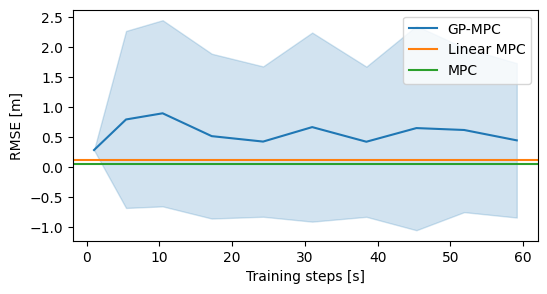

In [ ]:
controller_name = ''
dt = 1/60
# prior = '200_300_rti/temp'
# data = benchmark_rmse_data(data_folder_path, controller_name, prior, dt)

# prior_hpo = '100_400_copy/temp'
# prior_hpo = '200_300_aggresive'
prior_hpo = '100_400/temp'
data_hpo = benchmark_rmse_data(data_folder_path, controller_name, prior_hpo, dt)
mean_hpo, std_hpo = data_hpo.get_mean_std()
mean_hpo[0, 0] = 1
print('mean_hpo', mean_hpo)
print('std_hpo', std_hpo)

# get the 25 % and 75 % quantile
merged_data = np.array(data_hpo.merged_data)
# merged_data = data_hpo.merged_data
rmse_data = merged_data[:, :, 1]
print('rmse_data', rmse_data)
q1 = np.percentile(rmse_data, 25, axis=0)
q3 = np.percentile(rmse_data, 75, axis=0)

print('q1', q1)
print('q3', q3)
print('mean_hpo', mean_hpo[:, 1])

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(mean_hpo[:, 0], mean_hpo[:, 1], label='GP-MPC', color=colors[0])
# ax.fill_between(mean_hpo[:, 0], q1, q3, alpha=0.2, color=colors[0])
ax.fill_between(mean_hpo[:, 0], mean_hpo[:, 1] - s * std_hpo, mean_hpo[:, 1] + s * std_hpo, alpha=0.2, color=colors[0])

rmse_lmpc = 0.11634496692276783
rmse_std_lmpc = 0.0032306407398551827
rmse_nmpc = 0.05096096290371684 
rmse_std_nmpc = 0.0046670871708050805

ax.axhline(y=rmse_lmpc, color=colors[1], label='Li  near MPC')
ax.axhline(y=rmse_nmpc, color=colors[2], label='MPC')
# ax.set_xscale('log')
# ax.set_ylim([0, 0.8])
# ax.set_xlim([0, 1e6])
ax.set_xlabel('Training steps [s]')
ax.set_ylabel('RMSE [m]')
ax.legend()

(25, 10)

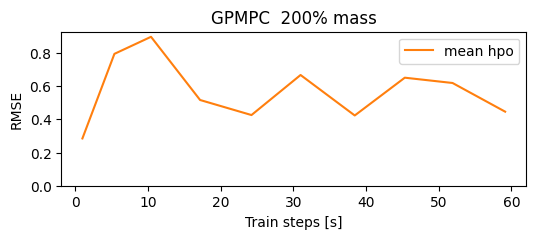

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
# mean, std = data.get_mean_std()
# ax.plot(mean[:, 0], mean[:, 1], label='mean', color=colors[0])
# ax.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, color=colors[0], alpha=0.2, label='std')

ax.plot(mean_hpo[:, 0], mean_hpo[:, 1], label='mean hpo', color=colors[1])
# ax.fill_between(mean_hpo[:, 0], mean_hpo[:, 1]-s*std_hpo, mean_hpo[:, 1]+s*std_hpo, color=colors[1], alpha=0.2, label='std hpo')
# ax.fill_between(mean_hpo[:, 0], q1, q3, color=colors[1], alpha=0.2, label='std hpo')

ax.legend(ncol=2, loc='upper right')
ax.set_ylim([0, None])
ax.set_xlabel('Train steps [s]')
ax.set_ylabel('RMSE')
ax.set_title(r'GPMPC  200% mass')
# set log x axis
# ax.set_xscale('log')

save_name = 'GPMPC_rmse_200_mass_50_sample_6_epoch'
fig.savefig(save_name+'.pdf', bbox_inches='tight')

results_hpo = {'rmse': rmse_data, 'train_steps': mean_hpo[:, 0]}
np.save('gpmpc.npy', results_hpo)
rmse_data.shape



In [24]:
rmse_data

array([[0.28630936, 0.05982058, 0.28829104, 0.05061444, 0.04963006,
        0.05639375, 0.84132871, 0.05864602, 1.00946163, 0.38999454],
       [0.28458793, 1.09810971, 2.10754249, 0.03991988, 0.04533763,
        1.88956605, 0.04620656, 0.22758406, 0.81736927, 1.04170062],
       [0.28458793, 1.09810971, 2.10754249, 0.03991988, 0.04533763,
        1.88956605, 0.04620656, 0.22758406, 0.81736927, 1.04170062],
       [0.28410577, 0.09063798, 1.46119739, 1.15472926, 1.90904177,
        1.340839  , 1.38946428, 1.4217137 , 1.44922776, 1.89579876],
       [0.28413072, 0.04254095, 0.03984011, 1.56935918, 0.03800731,
        0.85036884, 1.5432578 , 0.04951293, 0.04101457, 0.03909865],
       [0.28569209, 0.07983206, 0.04806048, 0.05799803, 1.25714393,
        1.64186209, 0.05401999, 1.84684771, 0.05214346, 0.05993937],
       [0.2848292 , 0.05547206, 0.05078195, 0.04943783, 0.98879843,
        0.05008306, 0.0633078 , 2.00556945, 0.10860449, 0.08250505],
       [0.28408237, 0.0497198 , 0.0690248

In [25]:
# for i in range(data.max_seed):
#     print(data.merged_data[i][:, 1])

In [26]:
rmse_ilqr = [0.027, 0.027, 0.030, 0.024, 0.026, 
             0.026, 0.025, 0.027, 0.025, 0.023]
rmse_mean_ilqr = np.mean(rmse_ilqr)
rmse_std_ilqr = np.std(rmse_ilqr)
print('rmse_ilqr', rmse_mean_ilqr, rmse_std_ilqr)
results_ilqr = {'mean': rmse_mean_ilqr, 'std': rmse_std_ilqr}
np.save('ilqr_ground_truth.npy', results_ilqr)

rmse_ilqr = [0.01288,0.01417,0.01680,0.00985,0.01194,
             0.01274,0.01160,0.01259,0.01091,0.00967,]
rmse_mean_ilqr = np.mean(rmse_ilqr)
rmse_std_ilqr = np.std(rmse_ilqr)
print('rmse_ilqr', rmse_mean_ilqr, rmse_std_ilqr)
results_ilqr = {'mean': rmse_mean_ilqr, 'std': rmse_std_ilqr}


rmse_ilqr 0.026000000000000002 0.001843908891458577
rmse_ilqr 0.012315 0.0019957417167559533


## MPC

In [27]:
#mpc
ctrl = 'mpc_acados'
for additinonal in ['_9', '_10', '_11', '_12', '_13', '_14', '_15']:
    data_folder = f'results_rollout{additinonal}/temp'
    traj_resutls, metrics = extract_rollouts(notebook_dir, data_folder, ctrl, additinonal)

traj_results.shape [array([[ 7.09423929e-03,  5.68015818e-02,  9.67287368e-01,
        -1.92911086e-02, -7.52523008e-03, -4.79404276e-03],
       [ 7.63011445e-03,  2.16059633e-02,  9.67707802e-01,
         6.08273131e-02,  1.36423712e-03,  1.31071081e+00],
       [ 8.01275880e-03,  4.29283117e-02,  9.69427783e-01,
         1.27772629e-01,  3.28422970e-02,  2.31840871e+00],
       ...,
       [-1.08645219e-01,  8.46961913e-01,  8.40118400e-01,
         6.77998369e-01, -3.17357327e-01, -3.28866450e-01],
       [-9.53325828e-02,  7.62136727e-01,  8.51151932e-01,
         6.60307135e-01, -3.21045419e-01, -2.52318372e-01],
       [-8.28391018e-02,  7.42949563e-01,  8.61753632e-01,
         6.24118197e-01, -3.24202937e-01, -6.47704636e-02]]), array([[-2.60733352e-02,  2.26653187e-02,  1.02219902e+00,
        -5.83881734e-02, -1.96314262e-02, -9.99361692e-04],
       [-2.56602769e-02,  1.00637699e-02,  1.02194885e+00,
         2.02036606e-02, -8.34430433e-03,  1.33733097e+00],
       [-2.523

## gpmpc

In [28]:
#gpmpc
ctrl = 'gpmpc_acados'
for additinonal in ['_9', '_10', '_11', '_12', '_13', '_14', '_15']:
    data_folder = f'results/100_400_rollout{additinonal}/temp'
    traj_resutls, metrics = extract_rollouts(notebook_dir, data_folder, ctrl, additinonal)

traj_results.shape [array([[-3.38110232e-02, -6.60547385e-02,  9.71789150e-01,
         1.79020013e-02, -5.03907672e-02, -5.43133964e-04],
       [-3.48783291e-02, -7.28596782e-02,  9.72382348e-01,
         8.55865805e-02, -3.63990179e-02,  1.39921214e+00],
       [-3.61654899e-02, -8.28771854e-02,  9.74252791e-01,
         1.50084075e-01, -5.73093068e-03,  2.47547710e+00],
       ...,
       [-1.13620674e-01,  8.13561474e-01,  8.50832090e-01,
         5.61225874e-01, -2.99198012e-01, -4.33710986e-01],
       [-1.00790503e-01,  7.36038022e-01,  8.60000166e-01,
         5.51353452e-01, -3.08078773e-01, -3.31492321e-01],
       [-8.87637020e-02,  7.24241489e-01,  8.68697268e-01,
         5.10622509e-01, -3.10278981e-01, -1.38425362e-01]]), array([[ 4.42373150e-02,  2.21367885e-03,  9.56553697e-01,
        -2.41212801e-02,  3.65136498e-02, -3.29093367e-03],
       [ 4.43319516e-02,  1.01101520e-03,  9.56795278e-01,
         5.85667543e-02,  4.66855926e-02,  1.22374576e+00],
       [ 4.473

## lmpc

In [29]:
#linear mpc
ctrl = 'linear_mpc'
for additinonal in ['_9', '_10', '_11', '_12', '_13', '_14', '_15']:
    data_folder = f'results_rollout{additinonal}/temp'
    traj_resutls, metrics = extract_rollouts(notebook_dir, data_folder, ctrl, additinonal)

traj_results.shape [array([[-8.09614129e-03,  6.95129550e-02,  1.00193416e+00,
         3.79592700e-02, -1.14272458e-02,  4.94167026e-03],
       [-7.23421711e-03,  5.87244404e-02,  1.00300645e+00,
         1.09496331e-01, -6.06510663e-04,  1.32677926e+00],
       [-6.40321071e-03,  6.98342640e-02,  1.00534183e+00,
         1.72316898e-01,  2.95308629e-02,  2.33213395e+00],
       ...,
       [-7.63776978e-02,  1.20037503e+00,  9.02736197e-01,
         9.30737272e-01, -1.92222844e-01, -1.07855863e+00],
       [-5.69353107e-02,  1.16372150e+00,  9.17676902e-01,
         8.72439050e-01, -2.10913976e-01, -1.05626821e+00],
       [-3.78778783e-02,  1.13057980e+00,  9.31826155e-01,
         8.31037471e-01, -2.27366230e-01, -1.00473224e+00]]), array([[ 4.44304205e-02,  4.29863623e-02,  9.57205064e-01,
        -1.50318315e-02, -4.29260974e-02,  4.16156170e-03],
       [ 4.49934437e-02,  2.81212392e-02,  9.57538721e-01,
         5.31860776e-02, -3.07079922e-02,  1.39284304e+00],
       [ 4.557

## pid

In [30]:
# pid
ctrl = 'pid'
for additinonal in ['_9', '_10', '_11', '_12', '_13', '_14', '_15']:
    data_folder = f'results_rollout{additinonal}/temp'
    traj_resutls, metrics = extract_rollouts(notebook_dir, data_folder, ctrl, additinonal)

traj_results.shape [array([[-0.02935352,  0.02217184,  1.01895103,  0.00597848,  0.0150048 ,
         0.00208912],
       [-0.02903908,  0.02268355,  1.01973637,  0.08658987,  0.02100262,
         0.7866901 ],
       [-0.02868779,  0.00523183,  1.02179597,  0.15360422,  0.03868971,
         1.41697707],
       ...,
       [-0.06797313,  1.38510674,  0.8356811 ,  1.70988442, -0.0805533 ,
         0.90230477],
       [-0.04510122,  1.37100015,  0.86432471,  1.73460718, -0.06721615,
         0.98894918],
       [-0.02233463,  1.35286464,  0.89328737,  1.73679467, -0.04845194,
         1.05147687]]), array([[ 0.02315193,  0.0284463 ,  1.02496263,  0.02462438, -0.02588139,
        -0.00552679],
       [ 0.02395943,  0.07044921,  1.02606128,  0.10937325, -0.0197402 ,
         0.817498  ],
       [ 0.02478225,  0.06495083,  1.02850839,  0.19097986, -0.00213158,
         1.43986051],
       ...,
       [-0.06783521,  1.42466673,  0.83362212,  1.71247542, -0.09592202,
         0.75947484],
    

In [32]:
# lqr
ctrl = 'lqr'
for additinonal in ['_9', '_10', '_11', '_12', '_13', '_14', '_15']:
    data_folder = f'results_rollout{additinonal}/temp'
    traj_resutls, metrics = extract_rollouts(notebook_dir, data_folder, ctrl, additinonal)

traj_results.shape [array([[ 1.16580779e-02, -2.94198385e-02,  1.01149387e+00,
        -1.39843289e-02, -1.11486542e-02, -1.24020736e-04],
       [ 1.11298743e-02, -1.91597900e-02,  1.01181894e+00,
         4.06273660e-02,  1.50517962e-03,  1.87040688e+00],
       [ 1.05285110e-02, -2.69940756e-02,  1.01332409e+00,
         1.21873909e-01,  4.70800661e-02,  3.30595874e+00],
       ...,
       [-9.33860636e-02,  1.51193892e+00,  9.19923343e-01,
         1.51798424e+00,  2.02405242e-02, -8.05397147e-02],
       [-6.82484577e-02,  1.55226088e+00,  9.45236370e-01,
         1.51038149e+00,  2.07822167e-02, -1.46499824e-01],
       [-4.29533983e-02,  1.51446245e+00,  9.70552224e-01,
         1.53394774e+00,  1.62537970e-02, -3.10139627e-01]]), array([[ 1.96599686e-02, -3.99343049e-03,  9.62118593e-01,
        -4.51745009e-02,  4.25296573e-02,  8.93193405e-04],
       [ 1.98320548e-02, -9.53509136e-03,  9.62274052e-01,
         4.74823739e-02,  5.82791402e-02,  1.74912366e+00],
       [ 2.014

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (50,) + inhomogeneous part.

In [19]:
ctrl = 'ilqr'
for additinonal in ['_9', '_10', '_11', '_12', '_13', '_14', '_15']:
    data_folder = f'results_rollout{additinonal}/temp'
    traj_resutls, metrics = extract_rollouts(notebook_dir, data_folder, ctrl, additinonal)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (50,) + inhomogeneous part.